In [2]:
from ddganAE.models import AAE, AAE_combined_loss, CAE, SVDAE
from ddganAE.architectures.cae.D3 import *
from ddganAE.architectures.svdae import *
from ddganAE.architectures.discriminators import *
from ddganAE.preprocessing import convert_2d
from keras.regularizers import l2
from ddganAE.utils import calc_pod
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 66793723999485893
]


# Let's look at data

In [4]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_200timesteps_rand.npy")

In [5]:
grids.shape

(4000, 60, 20, 20, 4)

In [3]:
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [4]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

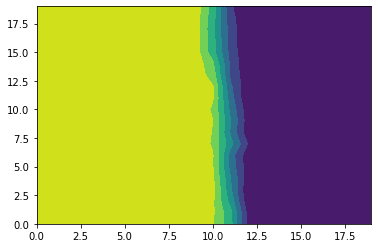

In [5]:
grid = grids[3000, 10, :, :, 3]
fig, ax = plt.subplots()
ax.contourf(grid)

In [6]:
grids.shape

(4000, 60, 20, 20, 4)

# POD

### Data preprocessing

In [7]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [8]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [9]:
grids_long = np.moveaxis(np.moveaxis(grids, 4, 0), 1, 4).reshape((grids.shape[-1], grids.shape[1]*grids.shape[2]*grids.shape[3], grids.shape[0]))

In [10]:
grids_long.shape

(4, 24000, 20)

### Do actual pod

In [11]:
coeffs, R, s = calc_pod(grids_long, nPOD=10)

### Check reconstruction loss

In [12]:
# Reconstruct the first subgrid
recon = R @ coeffs[0]
print(recon, '\n',
      grids_long[0, :, :])

np.allclose(recon, grids_long[0, :, :], atol=0.4)

[[0.36692773 0.35572533 0.36191009 ... 0.302274   0.31618407 0.3117868 ]
 [0.36405241 0.35317233 0.35142523 ... 0.29843277 0.31100294 0.30647323]
 [0.36449341 0.35327822 0.3538105  ... 0.29907561 0.31152679 0.3068394 ]
 ...
 [0.90214491 0.89062138 0.8892434  ... 0.78062268 0.80242384 0.79369137]
 [0.90194255 0.89061864 0.88970088 ... 0.78173231 0.80292679 0.79454682]
 [0.90184238 0.8906173  0.88992733 ... 0.78228149 0.80317572 0.7949702 ]] 
 [[0.35703304 0.35703304 0.35703304 ... 0.30065912 0.3220257  0.30020997]
 [0.35703304 0.35703304 0.35703304 ... 0.31459922 0.30087286 0.2770897 ]
 [0.35703304 0.35703304 0.35703304 ... 0.31458774 0.30147338 0.27534238]
 ...
 [0.8925826  0.8925826  0.8925826  ... 0.79801476 0.79199255 0.8128894 ]
 [0.8925826  0.8925826  0.8925826  ... 0.799796   0.7923931  0.8138338 ]
 [0.8925826  0.8925826  0.8925826  ... 0.8006776  0.79259133 0.8143012 ]]


True

In [17]:
# Calculate MSE
mean = 0
recon_grid = np.zeros(grids_long.shape)
for j in range(4):
    recon = R @ coeffs[j]
    for i in range(20):
        mean += tf.keras.losses.MSE(recon[:, i], grids_long[j, :, i]).numpy()/80
    recon_grid[j, :, :] = recon
print(mean)

0.00024860071133114836


In [18]:
np.array(coeffs).shape

(4, 10, 20)

### Reconstruct back to original shape

In [19]:
grids_recon = np.swapaxes(recon_grid, 0, 2).reshape(*grids.shape)

In [20]:
np.allclose(grids, grids_recon, atol=0.4)

True

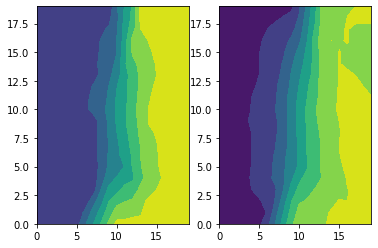

In [26]:
idx = 12
grid = grids[idx, 10, :, :, 0]
grid_recon = grids_recon[idx, 10, :, :, 0]
fig, ax = plt.subplots(1,2)
ax[0].contourf(grid)
ax[1].contourf(grid_recon)

# Convolutional Autoencoder

### Data preprocessing

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")

In [3]:
grids.shape

(20, 60, 20, 20, 4)

In [4]:
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [5]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [6]:
x_train, x_val = train_test_split(grids, test_size=0.1)

### Model setup

In [7]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

input_shape = (60, 20, 20, 4)

encoder, decoder = build_deeper_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')

cae = CAE(encoder, decoder, optimizer)
cae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 20, 20, 32)    16032     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 10, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 5, 5, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 5, 5, 64)      110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 3, 3, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 3, 3, 128)      2

In [8]:
cae.train(grids, 50, val_data=grids, batch_size=2)

KeyboardInterrupt: 

### Predict and generate outputs

In [9]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")

# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [10]:
out_grids = cae.predict(grids)

In [11]:
out_grids.shape

(20, 60, 20, 20, 4)

In [12]:
# reshape to (ngrids, nscalar, nx, ny, nz, ntime)
np.save("cae_reconstruction_sf.npy", out_grids)

In [13]:
out_grids.shape

(20, 60, 20, 20, 4)

In [14]:
out = out_grids[6, 10, :, :, 0]
orig = grids[6, 10, :, :, 0]

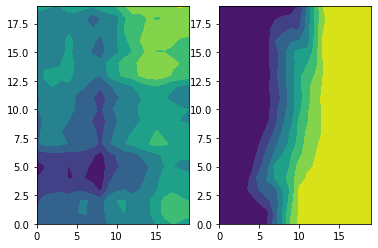

In [15]:
fig, ax = plt.subplots(1,2)
ax[0].contourf(out)
ax[1].contourf(orig)

# Adversarial Autoencoder

### Preprocessing

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")

In [3]:
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [4]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [5]:
x_train, x_val = train_test_split(grids, test_size=0.1)

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.00005, beta_1=0.9, beta_2=0.999)

input_shape = (60, 20, 20, 4)

encoder, decoder = build_deeper_omata_encoder_decoder(input_shape, 10, initializer, info=True, act='elu', dense_act='relu')
discriminator = build_custom_discriminator(10, initializer, info=True)

aae = AAE_combined_loss(encoder, decoder, discriminator, optimizer)
aae.compile(input_shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 60, 20, 20, 32)    16032     
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 30, 10, 10, 32)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 10, 10, 64)    55360     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 5, 5, 64)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 5, 5, 64)      110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 8, 3, 3, 64)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 8, 3, 3, 128)      2

In [7]:
aae.train(x_train, 50, val_data=x_val, batch_size=2, val_batch_size=2)

KeyboardInterrupt: 

# SVD Autoencoder

### Preprocessing

In [2]:
grids = np.load("./../submodules/DD-GAN/data/processed/sf_snapshots_2timesteps_notrand.npy")
# Set all >0 to 0 and all <1 to 1 for alpha field
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] < 0)] = 0
grids[:,:,:,:,3][np.where(grids[:,:,:,:,3] > 1)] = 1

In [3]:
# Rescale all the velocity fields
scaler = MinMaxScaler()
grids[:,:,:,:,:3] = scaler.fit_transform(grids[:,:,:,:,:3].reshape(-1, 1)).reshape(grids[:,:,:,:,:3].shape)

In [4]:
x_train, x_val = train_test_split(grids, test_size=0.1 )

In [5]:
x_train_long = np.moveaxis(np.moveaxis(x_train, 4, 0), 1, 4).reshape((x_train.shape[-1], x_train.shape[1]*x_train.shape[2]*x_train.shape[3], x_train.shape[0]))
x_val_long = np.moveaxis(np.moveaxis(x_val, 4, 0), 1, 4).reshape((x_val.shape[-1], x_val.shape[1]*x_val.shape[2]*x_val.shape[3], x_val.shape[0]))

### Set up model

In [6]:
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
optimizer = tf.keras.optimizers.Nadam(lr=0.0005, beta_1=0.98, beta_2=0.99999)

encoder, decoder = build_vinicius_encoder_decoder(100, 10, initializer, act='elu', dense_act='relu', info=True, reg=0, dropout=0.55, batchnorm=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              827392    
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0

In [7]:
svdae = SVDAE(encoder, decoder, optimizer)
svdae.compile(100, weight_loss=False)

# Only set this when loading in the model
#svdae.R = np.load("R_svdae.npy")

In [8]:
svdae.train(x_train_long, 150, val_data=x_val_long, batch_size=2, val_batch_size=2)

In [15]:
original = x_train_long[0, :, 15]
original.shape

(24000,)

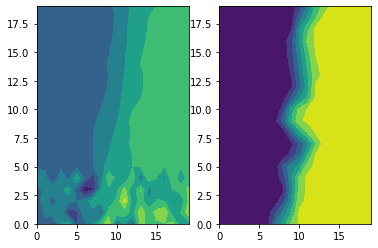

In [16]:
result = svdae.predict_single(original)
result = result.reshape((1, 60, 20, 20, 1))

original = original.reshape((1, 60, 20, 20, 1))

fig, ax = plt.subplots(1,2)
ax[0].contourf(result[0][0, :, :, 0])
ax[1].contourf(original[0][0, :, :, 0])

In [ ]:
Create data on the fly! Keep randomly sampling!

In [8]:
# Configuration options for hyperparameter optimization
cae_sweep_config = {
    "method": "random",
    "metric": {"name": "valid_loss", "goal": "minimize"},
    "parameters": {
        "architecture": {"values": ["denser_omata",
                                    "densest_thinner_omata", "omata",
                                    "wide_omata"]},
        "activation": {"values": ["elu", "sigmoid", "relu", "tanh"]},
        "dense_activation": {"values": ["relu", None]},
        "batch_size": {"values": [32, 64, 128]},
        "learning_rate": {"values": [5e-3, 5e-4, 5e-5, 5e-6]},
        "optimizer": {"values": ["nadam", "adam", "sgd"]},
        "momentum": {"values": [0.8, 0.9, 0.98]},
        "beta_2": {"values": [0.9, 0.999, 0.99999]},
        "savemodel": {"values": [False]}
    },
}

import json
with open('data.json', 'w', encoding='utf-8') as f:
    json.dump(cae_sweep_config, f, ensure_ascii=False, indent=4)